# Deep Learning for Media 
#### MPATE-GE 2039 - DM-GY 9103 

---

## Evaluating Pre-Trained Model Performance on Genre Classification for Movie Trailers


In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/My Drive/dl4m_datasets/"

modules_path = os.path.join(root_dir, "trailer_dataset", "trailer_model_data")
print(os.path.exists(modules_path))

import sys
sys.path.append(modules_path)

import models as m

import utils as u

import json

import data_collection_utils as data_utils



# Fix the random seed for reproducibility
from numpy.random import seed
seed(123)
import tensorflow as tf
tf.keras.utils.set_random_seed(123)

data_home = '/content/drive/My Drive/dl4m_datasets/trailer_dataset/' 


True


In [ ]:
!pip install pytube
!pip install opencv-python
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Part 1 - Collecting the Data

Uses PyTube and MoviePy to create three folderes, train, test, and validation, each with a folder for frame and a folder for audio.

In [ ]:
# get a txt file where each line is a movie, like this: 
# ['Creed III', 677179, [1, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'xTaIZo8OJYE']


data_utils.collect_data(500)

ids = data_utils.get_dataset_ids("dataset.txt")

# the below functions work when run locally, not in Colab


download_frames_retry (
    "/mnt/h/My Drive/dl4m_datasets/trailer_dataset/train/frames/", 
    "/mnt/h/My Drive/dl4m_datasets/trailer_dataset/train/audio/", 
    ids[0:2875], '
    30
)

download_frames_retry (
    "/mnt/h/My Drive/dl4m_datasets/trailer_dataset/test/frames/", 
    "/mnt/h/My Drive/dl4m_datasets/trailer_dataset/test/audio/", 
    ids[2875:3474], '
    30
)

download_frames_retry (
    "/mnt/h/My Drive/dl4m_datasets/trailer_dataset/validation/frames/", 
    "/mnt/h/My Drive/dl4m_datasets/trailer_dataset/validation/audio/", 
    ids[3474:3993], '
    30
)

  all_good = confirm_dataset()
  print(all_good)


## Getting information about the data

See which genres are most common and most commonly associated.

In [ ]:


genres_path = os.path.join(modules_path, "genres.json")

labels_dict = {}

# Open the JSON file
with open(genres_path, 'r') as f:
    # Load the JSON data as a dictionary
    labels_dict = json.load(f)


data_home = '/content/drive/My Drive/dl4m_datasets/trailer_dataset/' 

if not os.path.exists(data_home):
  print('Dataset not found')


In [ ]:
# Create datasets
data_home = '/content/drive/My Drive/dl4m_datasets/trailer_dataset/' 
batch_size = 64
target_shape = (180, 180)

single_label = False

train_dataset = u.create_dataset(os.path.join(data_home, 'train', 'frames'), 
                                 batch_size, target_shape, single=single_label)

val_dataset = u.create_dataset(os.path.join(data_home, 'validation', 'frames'), 
                                 batch_size, target_shape, single=single_label)

test_dataset = u.create_dataset(os.path.join(data_home, 'test', 'frames'), 
                                 batch_size, target_shape, single=single_label)

In [ ]:
genre_names = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Mystery', 'Romance', 'Science Fiction', 'Thriller']
all_labels =np.load(os.path.join(data_home, "trailer_model_data", 'all_labels.npy'))

def find_common_sets(n, arr_list, k):
    # Count the occurrence of sets of n indices where all n indices have a value of 1
    counter = Counter()
    for arr in arr_list:
        one_indices = [i for i, val in enumerate(arr) if val == 1]
        for indices in _combinations(one_indices, n):
            counter[tuple(indices)] += 1

    # Get the k most common sets of n indices
    most_common_sets = counter.most_common(k)

    # Output the most common sets of n indices
    sets = [set for set, count in most_common_sets]
    counts = [count for set, count in most_common_sets]
    return sets, counts


def _combinations(lst, n):
    if n == 0:
        return [[]]
    l = []
    for i in range(0, len(lst)):
        m = lst[i]
        rem_lst = lst[i+1:]
        for p in _combinations(rem_lst, n-1):
            l.append([m]+p)
    return l

def print_common_sets(n, arr_list, k):
  print(f"Top {k} groups of {n}")
  indices, counts = find_common_sets(n, arr_list, k)
  print(indices)
  for ind, i in enumerate(indices):
    genres = ""
    for j in i:
      genres += genre_names[j] + " "
    print(f"{genres}| {counts[ind]}")

for i in range(1,7):
  print_common_sets(i, all_labels, 5)
  print("\n")



Top 5 groups of 1
[(4,), (2,), (9,), (0,), (1,)]
Drama | 1404
Comedy | 1190
Thriller | 1167
Action | 1074
Adventure | 788


Top 5 groups of 2
[(0, 9), (4, 9), (0, 1), (3, 9), (5, 9)]
Action Thriller | 439
Drama Thriller | 408
Action Adventure | 397
Crime Thriller | 335
Horror Thriller | 334


Top 5 groups of 3
[(0, 1, 8), (0, 3, 9), (3, 4, 9), (0, 4, 9), (0, 8, 9)]
Action Adventure Science Fiction | 178
Action Crime Thriller | 163
Crime Drama Thriller | 159
Action Drama Thriller | 100
Action Science Fiction Thriller | 95


Top 5 groups of 4
[(0, 3, 4, 9), (0, 1, 8, 9), (3, 4, 6, 9), (0, 1, 2, 8), (0, 1, 3, 9)]
Action Crime Drama Thriller | 49
Action Adventure Science Fiction Thriller | 39
Crime Drama Mystery Thriller | 21
Action Adventure Comedy Science Fiction | 20
Action Adventure Crime Thriller | 18


Top 5 groups of 5
[(0, 1, 2, 3, 9), (0, 3, 4, 6, 9), (0, 2, 3, 4, 9), (0, 1, 6, 8, 9), (0, 1, 3, 8, 9)]
Action Adventure Comedy Crime Thriller | 5
Action Crime Drama Mystery Thriller |

[440, 240, 1010, 320, 1610, 530, 170, 350, 300, 670] [320, 230, 890, 240, 1450, 350, 140, 410, 120, 790]


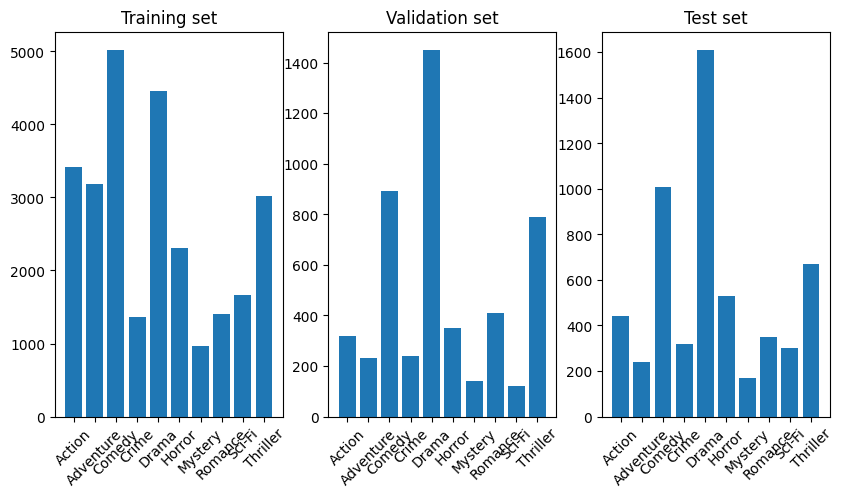

In [ ]:
# Explore the data
# WARNING: loading all the data might take a bit of time
# u.explore_data(train_dataset, os.path.join(data_home, 'train', 'frames'), ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'])
u.explore_data(train_dataset, data_home, labels_dict, ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller'])

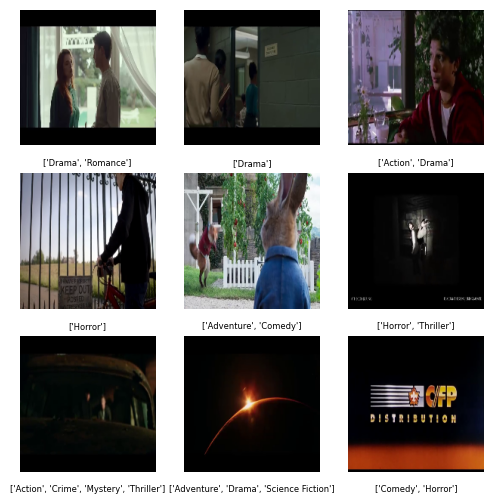

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for batch, labels in train_dataset.take(3):
    images = batch[:9]
    labels = labels[:9]
    

# Plot the images
plt.figure(figsize=(6, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

    # label = labels[i].numpy()
    label = u.convert_genres(labels[i])

    plt.text(0.5, -0.15, f"{label}", fontsize=6, ha='center', transform=ax.transAxes)

plt.show()

## Build, train and evaluate a baseline

Trains a convolutional baseline model that learns from scratch.

In [ ]:
# Build baseline
input_shape = (180, 180, 3)
baseline = m.build_baseline(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
baseline.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 dense_4 (Dense)             (None, 180, 180, 128)     512       
                                                                 
 flatten_4 (Flatten)         (None, 4147200)           0         
                                                                 
 dropout_4 (Dropout)         (None, 4147200)           0         
                                                                 
 dense_5 (Dense)             (None, 10)                41472010  
                                                                 
Total params: 41,472,522
Trainable params: 41,472,522
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define callbacks
import keras

baseline_path = os.path.join(data_home, "trailer_model_data", "baseline_2.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=baseline_path,
        save_best_only=True,
        monitor="val_loss")
]

history = baseline.fit(
              train_dataset.prefetch(tf.data.AUTOTUNE), 
              validation_data=val_dataset.prefetch(tf.data.AUTOTUNE),
              epochs=30, 
              batch_size=batch_size,
              callbacks=callbacks)

Epoch 1/30
    768/Unknown - 24313s 31s/step - loss: 0.5235 - accuracy: 0.2372

In [ ]:
u.plot_loss(history)

In [ ]:
import numpy as np

# # Load the best checkpoint of the model
baseline_path = os.path.join(data_home, "trailer_model_data", "baseline.keras")

test_model = keras.models.load_model(baseline_path)

# Evaluate model
loss, accuracy = test_model.evaluate(test_dataset)
print('Loss: %.4f, Accuracy: %.2f%%' % (loss, accuracy*100))

save_path = os.path.join(data_home, "trailer_model_data", 'predictions_baseline.npy')
np.save(save_path, test_model.predict(test_dataset))

176/176 [==============================] - 47s 255ms/step - loss: 0.4802 - accuracy: 0.3208
Loss: 0.4802, Accuracy: 32.08%
176/176 [==============================] - 46s 256ms/step


##Leveraging a pretrained model

Used a VGG16 convolutional model trained with Imagenet to extract features from the movie trailer frames. Passed these features to a model withe a Conv2d layer.

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = m.load_conv_model()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

train_features, train_labels =  u.get_features_and_labels(train_dataset, conv_base)

save_path = os.path.join(data_home, "trailer_model_data", 'train_features.npy')
np.save(save_path, train_features)

save_path = os.path.join(data_home, "trailer_model_data", 'train_labels.npy')
np.save(save_path, train_labels)

val_features, val_labels =  u.get_features_and_labels(val_dataset, conv_base)

save_path = os.path.join(data_home, "trailer_model_data", 'val_features.npy')
np.save(save_path, val_features)

save_path = os.path.join(data_home, "trailer_model_data", 'val_labels.npy')
np.save(save_path, val_labels)

test_features, test_labels =  u.get_features_and_labels(test_dataset, conv_base)


save_path = os.path.join(data_home, "trailer_model_data", 'test_features.npy')
np.save(save_path, test_features)

save_path = os.path.join(data_home, "trailer_model_data", 'test_labels.npy')
np.save(save_path, test_labels)

In [ ]:
train_features.shape

(26752, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
import keras
import numpy as np

train_features = np.load(os.path.join(data_home, "trailer_model_data", 'train_features.npy'))
train_labels =np.load(os.path.join(data_home, "trailer_model_data", 'train_labels.npy'))

val_features = np.load(os.path.join(data_home, "trailer_model_data", 'val_features.npy'))
val_labels = np.load(os.path.join(data_home, "trailer_model_data", 'val_labels.npy'))
single_label = False

if single_label:
  extraction_path = os.path.join(data_home, "trailer_model_data", "feature_extraction_single_label.keras")
else:
  extraction_path = os.path.join(data_home, "trailer_model_data", "feature_extraction.keras")

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=extraction_path,
      save_best_only=True,
      monitor="val_loss")
      
dense_model = m.build_dense_model(input_shape=train_features.shape[1:])

history = dense_model.fit(
    train_features, train_labels,
    epochs=500,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


(5, 5, 512)
{0: 1.525199543899658, 1: 1.9424920127795526, 2: 1.5823967822075002, 3: 3.455437871351072, 4: 1.5020774845592364, 5: 2.8624010271774023, 6: 5.021021021021021, 7: 4.291305742701315, 8: 3.095579726915066, 9: 1.6338096983021864}
{0: 0.3050399087799316, 1: 0.38849840255591056, 2: 0.31647935644150005, 3: 0.6910875742702144, 4: 0.30041549691184727, 5: 0.5724802054354804, 6: 1.0042042042042043, 7: 0.858261148540263, 8: 0.6191159453830132, 9: 0.32676193966043726}
Epoch 1/500
836/836 [==============================] - 17s 8ms/step - loss: 0.5235 - accuracy: 0.2025 - val_loss: 0.4885 - val_accuracy: 0.2579
Epoch 2/500
836/836 [==============================] - 6s 7ms/step - loss: 0.5153 - accuracy: 0.2174 - val_loss: 0.4899 - val_accuracy: 0.3074
Epoch 3/500
836/836 [==============================] - 9s 11ms/step - loss: 0.5140 - accuracy: 0.2212 - val_loss: 0.4917 - val_accuracy: 0.2754
Epoch 4/500
836/836 [==============================] - 5s 7ms/step - loss: 0.5120 - accuracy: 0.2

**Plotting the results**

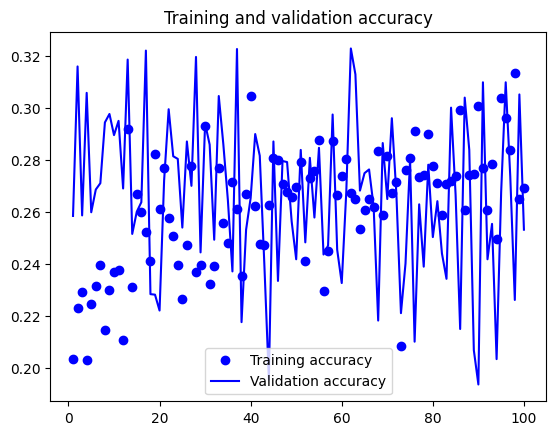

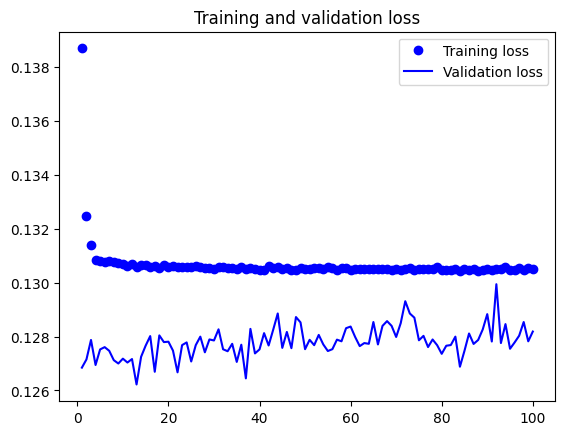

In [ ]:
u.plot_loss(history)

In [ ]:
# Load the best checkpoint of the model
# base = "/content/drive/My Drive/dl4m_datasets/"
# save_path = os.path.join(base, 'feature_extraction.keras')
import keras
import numpy as np

single_label = False
if single_label:
  extraction_path = os.path.join(data_home, "trailer_model_data", "feature_extraction_single_label.keras")
else:
  extraction_path = os.path.join(data_home, "trailer_model_data", "feature_extraction.keras")


transf_model = keras.models.load_model(extraction_path)
# transf_model = keras.models.load_model("maybe.keras")

test_features = np.load(os.path.join(data_home, "trailer_model_data", 'test_features.npy'))
test_labels = np.load(os.path.join(data_home, "trailer_model_data", 'test_labels.npy'))

# Evaluate model
loss, accuracy = transf_model.evaluate(test_features, test_labels)
print('Loss: %.4f, Accuracy: %.2f%%' % (loss, accuracy*100))

176/176 [==============================] - 9s 3ms/step - loss: 0.1279 - accuracy: 0.3097
Loss: 0.1279, Accuracy: 30.97%


**Visualizing the results**

176/176 [==============================] - 1s 3ms/step


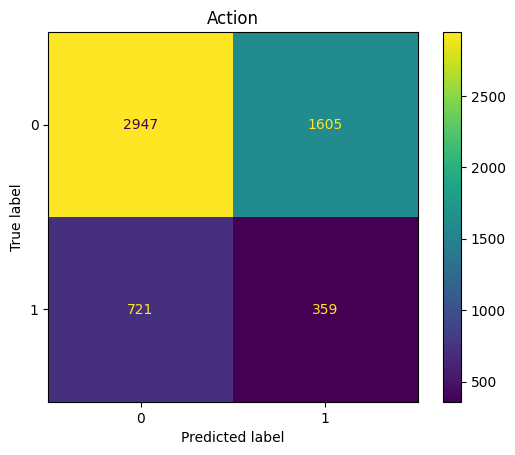

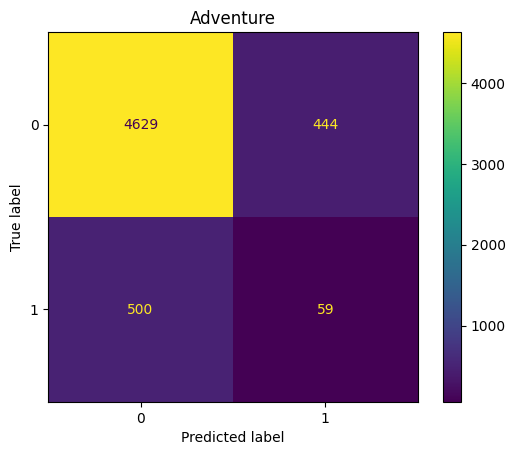

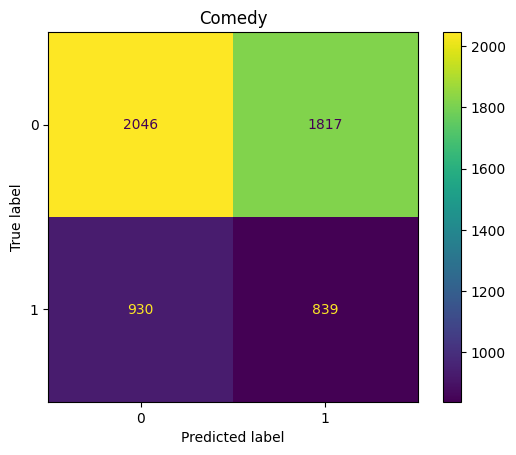

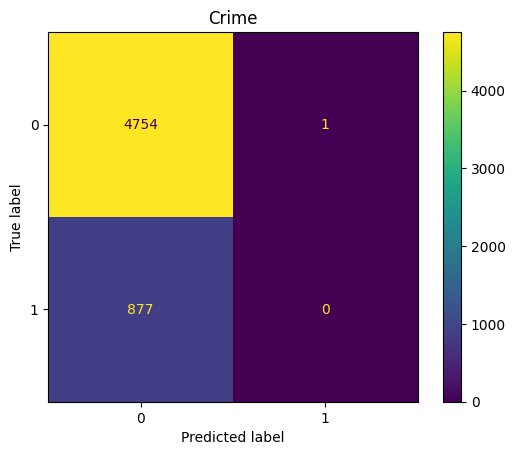

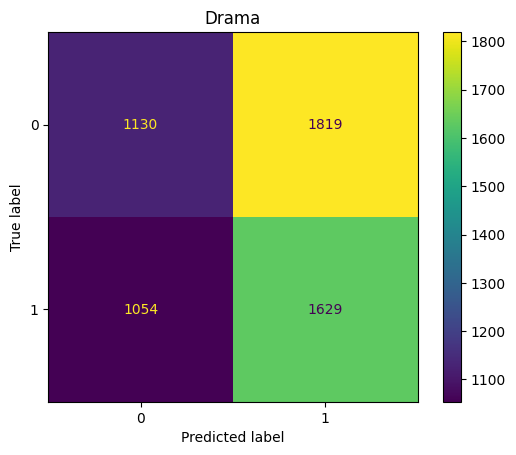

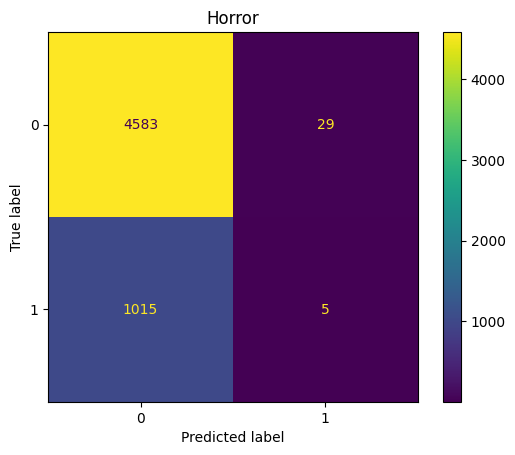

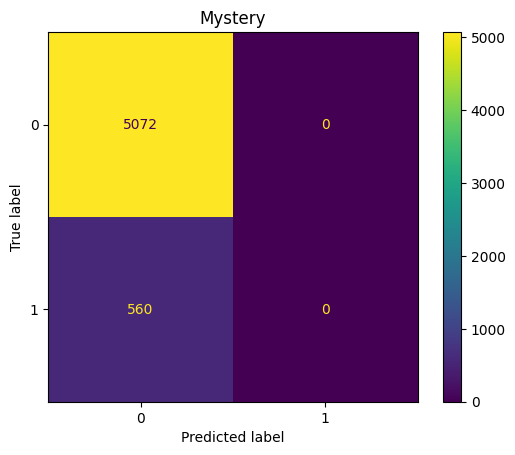

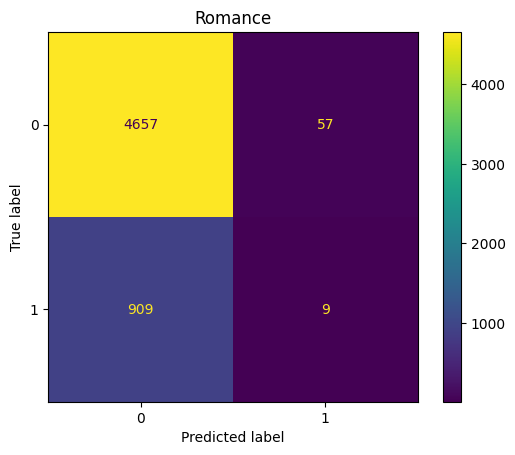

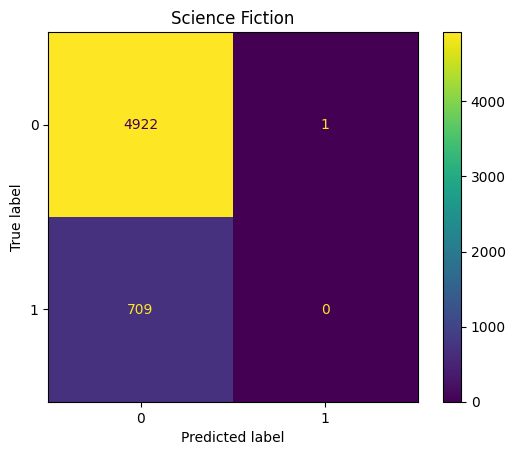

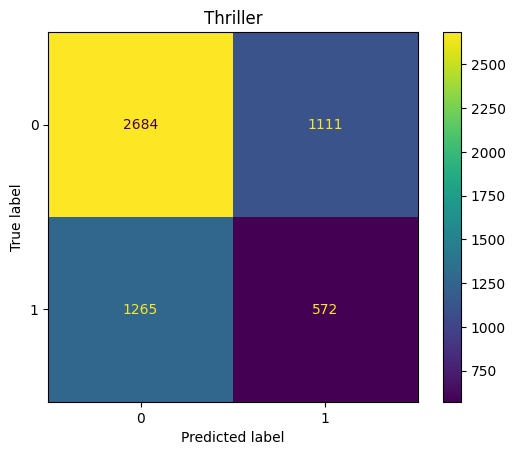

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

genre_names = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Mystery', 'Romance', 'Science Fiction', 'Thriller']

transf_model = keras.models.load_model(extraction_path)
y_pred = transf_model.predict(test_features)
save_path = os.path.join(data_home, "trailer_model_data", 'transfer_model_pred.npy')
np.save(save_path, y_pred)

# Get the predictions for the test set
save_path = os.path.join(data_home, "trailer_model_data", 'transfer_model_pred.npy')
y_pred = np.load(save_path)

test_labels_path = os.path.join(data_home, "trailer_model_data", 'test_labels.npy')
test_labels = np.load(test_labels_path)

baseline_path = os.path.join(data_home, "trailer_model_data", "baseline.keras")
baseline_model = keras.models.load_model(baseline_path)

baseline_predictions_path = os.path.join(data_home, "trailer_model_data", 'predictions_baseline.npy')
y_pred = np.load(baseline_predictions_path)


transf_model_y_pred_30 = (y_pred > .34)

transf_model_y_confusion_30 = multilabel_confusion_matrix(y_true = test_labels, y_pred = transf_model_y_pred_30 )

# plot and save confusion matrix for each genre
for conf, genre in zip(transf_model_y_confusion_30, genre_names):
  disp = ConfusionMatrixDisplay(conf)
  disp.plot()
  plt.title(genre)
  plt.savefig(str(genre)+"_cnn_conf.png")



  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



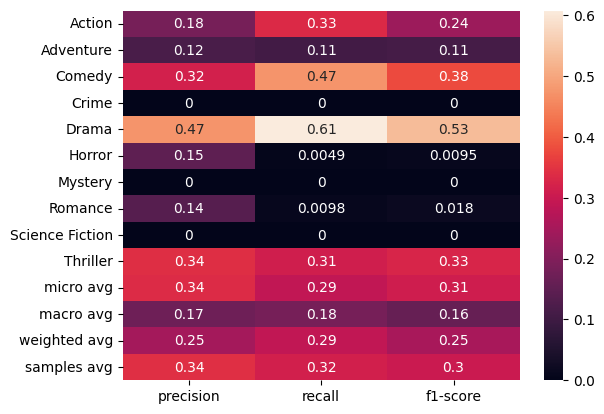

In [ ]:
transf_model_class = classification_report(y_true = test_labels, y_pred = transf_model_y_pred_30, target_names= genre_names, output_dict = True)


cnn_heatmap = sns.heatmap(pd.DataFrame(transf_model_class).iloc[:-1, :].T, annot=True)
fig = cnn_heatmap.get_figure()
fig.savefig("cnn_class_heatmap.png")